## 1 Preliminaries

## 1.1 Imports and Configurations

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from pandas.api.types import CategoricalDtype
from sklearn.feature_selection import mutual_info_regression

warnings.filterwarnings('ignore')

### Constants

In [2]:
# 1 Preliminaries

MARKETING_PATH =  Path('../data/raw/marketing_campaign.xls')

FEATURES_TO_DEL = ['ID', 'Z_CostContact', 'Z_Revenue']
FEATURES_NUM = ['Year_Birth', 'Income', 'Recency', 'MntWines', 'MntFruits',  'MntMeatProducts', 
                'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 
                'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
FEATURES_CAT = ['Marital_Status', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 
                'AcceptedCmp5', 'Complain', 'Response']
FEATURES_DATE = ['Dt_Customer']

FEATURES_ORD_LEVELS = {
    'Education': ['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD'],
    'Kidhome': [0, 1, 2],
    'Teenhome': [0, 1, 2],
}

# 2 Feature Utility Scores

MI_SCORES_FEATURE_TO_ESTIMATE = 'Income'
MI_SCORES_THRESHOLD = 0.01

## 3 Feature Engineering

CUR_YEAR = 2023

## 1.2 Data Preprocessing

### Read

In [3]:
def read_data(path):
    return pd.read_csv(path, sep='\t')

In [4]:
df = read_data(MARKETING_PATH)
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### Clean

In [5]:
def clean(df, features_to_del):
    df = df.drop(columns=features_to_del)
    df = df.rename(columns={
        'MntWines': 'Wines', 'MntFruits': 'Fruits', 'MntMeatProducts': 'Meat',
        'MntFishProducts': 'Fish', 'MntSweetProducts': 'Sweet', 'MntGoldProds': 'Gold',
    })
    return df

In [6]:
df_cleaned = clean(df, FEATURES_TO_DEL) 
df_cleaned.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,Wines,Fruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,...,10,4,7,0,0,0,0,0,0,1
1,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,...,1,2,5,0,0,0,0,0,0,0
2,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,...,2,10,4,0,0,0,0,0,0,0
3,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,...,0,4,6,0,0,0,0,0,0,0
4,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,...,3,6,5,0,0,0,0,0,0,0


### Encode

In [7]:
def encode(df, features_cat, features_date, features_ord_levels):
    def encode_cat(df, features_cat):
        for feature in features_cat:
            df[feature] = df[feature].astype('category')
        return df

    def encode_date(df, features_date):
        for feature in features_date:
            df[feature] = pd.to_datetime(df[feature])
        return df

    def encode_ord(df, features_ord_levels):
        for feature, levels in features_ord_levels.items():
            df[feature] = df[feature].astype(CategoricalDtype(levels, ordered=True))
        return df
    
    df = encode_cat(df, features_cat)
    df = encode_date(df, features_date)
    df = encode_ord(df, features_ord_levels)
    return df

In [8]:
df_encoded = encode(df_cleaned, FEATURES_CAT,  FEATURES_DATE, FEATURES_ORD_LEVELS)
df_encoded.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,Wines,Fruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,88,...,10,4,7,0,0,0,0,0,0,1
1,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,1,...,1,2,5,0,0,0,0,0,0,0
2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,2,10,4,0,0,0,0,0,0,0
3,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,11,4,...,0,4,6,0,0,0,0,0,0,0
4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,3,6,5,0,0,0,0,0,0,0


In [9]:
df_encoded.dtypes

Year_Birth                      int64
Education                    category
Marital_Status               category
Income                        float64
Kidhome                      category
Teenhome                     category
Dt_Customer            datetime64[ns]
Recency                         int64
Wines                           int64
Fruits                          int64
Meat                            int64
Fish                            int64
Sweet                           int64
Gold                            int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                 category
AcceptedCmp4                 category
AcceptedCmp5                 category
AcceptedCmp1                 category
AcceptedCmp2                 category
Complain                     category
Response                     category
dtype: objec

### Missing Values

In [10]:
def impute(df):
    return df.dropna()

In [11]:
df_imputed = impute(df_encoded)
df_imputed.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,Wines,Fruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,88,...,10,4,7,0,0,0,0,0,0,1
1,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,1,...,1,2,5,0,0,0,0,0,0,0
2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,2,10,4,0,0,0,0,0,0,0
3,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,11,4,...,0,4,6,0,0,0,0,0,0,0
4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,3,6,5,0,0,0,0,0,0,0


In [12]:
df_imputed.isna().sum().sum()

0

### Summary

In [13]:
def load_data(path, features_to_del, features_cat, features_date, features_features_ord_levels):
    df = read_data(path)
    df = clean(df, features_to_del)
    df = encode(df, features_cat, features_date, features_features_ord_levels)
    df = impute(df)
    return df

In [14]:
df = load_data(MARKETING_PATH, FEATURES_TO_DEL, FEATURES_CAT, FEATURES_DATE, FEATURES_ORD_LEVELS)
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,Wines,Fruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,88,...,10,4,7,0,0,0,0,0,0,1
1,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,1,...,1,2,5,0,0,0,0,0,0,0
2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,2,10,4,0,0,0,0,0,0,0
3,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,11,4,...,0,4,6,0,0,0,0,0,0,0
4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,3,6,5,0,0,0,0,0,0,0


In [15]:
df.dtypes

Year_Birth                      int64
Education                    category
Marital_Status               category
Income                        float64
Kidhome                      category
Teenhome                     category
Dt_Customer            datetime64[ns]
Recency                         int64
Wines                           int64
Fruits                          int64
Meat                            int64
Fish                            int64
Sweet                           int64
Gold                            int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                 category
AcceptedCmp4                 category
AcceptedCmp5                 category
AcceptedCmp1                 category
AcceptedCmp2                 category
Complain                     category
Response                     category
dtype: objec

## 2 Feature Utility Scores

## 2.1 MI Scores

In [16]:
def make_mi_scores(X, y):
    X = X.copy()
    for feature in X.select_dtypes(['object', 'category', 'datetime64[ns]']):
        X[feature], _ = X[feature].factorize()
        
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [17]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutual Information Scores')

In [18]:
X_mi = df.copy()
y_mi = X_mi.pop('Income')

mi_scores = make_mi_scores(X_mi, y_mi)
mi_scores

Wines                  0.908864
Meat                   0.781931
NumCatalogPurchases    0.571034
NumStorePurchases      0.536866
Fruits                 0.492440
Fish                   0.470758
Sweet                  0.449503
NumWebVisitsMonth      0.400955
Gold                   0.352573
NumWebPurchases        0.346588
NumDealsPurchases      0.256640
Kidhome                0.215081
Teenhome               0.175577
Dt_Customer            0.167023
Year_Birth             0.134260
Education              0.129305
AcceptedCmp5           0.121115
Recency                0.096549
Marital_Status         0.079938
AcceptedCmp1           0.073276
Response               0.038594
AcceptedCmp4           0.036665
AcceptedCmp3           0.018194
AcceptedCmp2           0.011546
Complain               0.002849
Name: MI Scores, dtype: float64

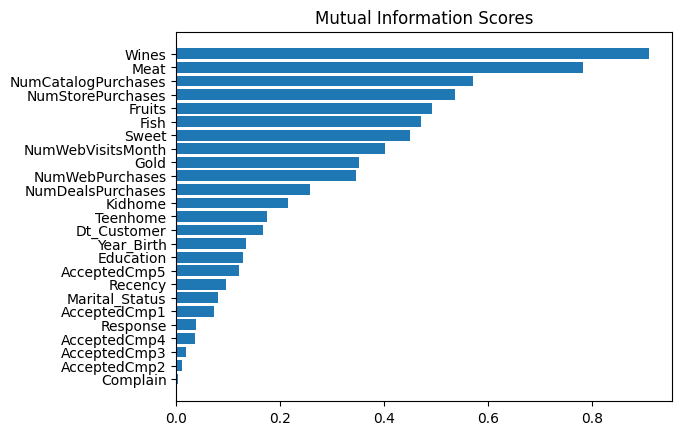

In [19]:
plot_mi_scores(mi_scores)

## 2.2 Drop Unfinformative

In [20]:
def drop_uninformative(df, feature_target, mi_scores, threshold):
    X = df.drop(columns=feature_target)
    X = X.loc[:, mi_scores > threshold]
    return X.join(df[feature_target])

In [21]:
df = drop_uninformative(df, MI_SCORES_FEATURE_TO_ESTIMATE, mi_scores, MI_SCORES_THRESHOLD)
df.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet',
       'Gold', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Response', 'Income'],
      dtype='object')

## 3 Feature Engineering

## 3.1 Create Features with Pandas

In [22]:
def math_transforms(df, cur_year):
    X = pd.DataFrame()
    X['Age'] = cur_year - df['Year_Birth']
    X['TotalSpent'] = df['Wines'] + df['Fruits'] + df['Meat'] + \
        df['Fish'] + df['Sweet'] + df['Gold']
    X['TotalAcceptedCmp'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 
                                'AcceptedCmp4', 'AcceptedCmp5']].astype(int).sum(axis=1)
    return X

In [23]:
def counts(df):
    X = pd.DataFrame()
    X['Children'] = df['Kidhome'].astype(int) + df['Teenhome'].astype(int)
    X['FamilySize'] = df['Marital_Status'].replace({
        'Married': 2, 'Together': 2, 'Absurd': 1, 'Widow': 1, 
        'YOLO': 1, 'Divorced': 1, 'Single': 1, 'Alone': 1,
    }).astype(int) + X['Children'].astype(int)
    return X

In [24]:
def indicators(df):
    X = pd.DataFrame()
    X['InRelationship'] = df['Marital_Status'].replace({
        'Married': 1, 'Together': 1, 'Absurd': 0, 'Widow': 0, 
        'YOLO': 0, 'Divorced': 0, 'Single': 0,
    }).astype('category')
    X['HasChildren'] = df[['Kidhome', 'Teenhome']] \
        .astype(int).sum(axis=1).gt(0).astype(int).astype('category')
    X['EducationLevel'] = df['Education'].replace({
        'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate', 'Graduation': 'Graduate', 
        'Master': 'Postgraduate', 'PhD': 'Postgraduate',
    }).astype('category')
    X['BoughtWeb'] = df['NumWebPurchases'].gt(0).astype(int).astype('category')
    X['BoughtCatalog'] = df['NumCatalogPurchases'].gt(0).astype(int).astype('category')
    X['BoughtStore'] = df['NumStorePurchases'].gt(0).astype(int).astype('category')
    X['AcceptedSmth'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 
                            'AcceptedCmp5']].astype(int).sum(axis=1).gt(0).astype(int).astype('category')
    return X

In [25]:
def group_transforms(df):
    X = pd.DataFrame()
    X['MedEducationIncome'] = df.groupby('Education')['Income'].transform('median')
    return X

In [50]:
def date_conversions(df):
    X = pd.DataFrame()
    dates = [d.date() for d in df['Dt_Customer']]
    d_max = max(dates)
    days = [(d_max - d).days for d in dates]
    X['CustomerLastDays'] = pd.to_numeric(days, errors='coerce')
    return X

## 3.2 Indicate Outliers

## 3.3 Summary 

In [51]:
def create_features(df, feature_target, mi_threshold, cur_year, df_test=None):
    X = df.copy()
    mi_scores = make_mi_scores(X.drop(columns=feature_target), X[feature_target])

    if df_test is not None:
        X_test = df_test.copy()
        X = pd.concat([X, X_test])

    X = drop_uninformative(X, feature_target, mi_scores, mi_threshold)
    X = X.join(math_transforms(X, cur_year))
    X = X.join(counts(X))
    X = X.join(indicators(X))
    X = X.join(group_transforms(X))
    X = X.join(date_conversions(X))

    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    return X

In [52]:
X_train = create_features(df, MI_SCORES_FEATURE_TO_ESTIMATE, MI_SCORES_THRESHOLD, CUR_YEAR)